In [1]:
import os, glob
import random
import torch
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt

from unet import UNet

In [2]:
NUM_CLASSES = 3
BATCH_SIZE = 1
#histogram_landmarks_path = 'landmarks.npy'
DATA_DIR = '/media/trojan/trojan/3D-CT-Artery-Segmentation/data_splitted'

In [3]:
validation_images_dir = os.path.join(DATA_DIR, 'val/volumes')
validation_labels_dir = os.path.join(DATA_DIR, 'val/masks')
validation_image_paths = sorted(glob.glob(validation_images_dir + '/' + '*.nii.gz'))
validation_label_paths = sorted(glob.glob(validation_labels_dir + '/' + '*.nii.gz'))
assert len(validation_image_paths) == len(validation_label_paths)

validation_subjects = []
for (image_path, label_path) in zip(validation_image_paths, validation_label_paths):
    subject = tio.Subject(
        image=tio.ScalarImage(image_path),
        label=tio.LabelMap(label_path),
    )
    validation_subjects.append(subject)
validation_dataset = tio.SubjectsDataset(validation_subjects)
print('Dataset size:', len(validation_dataset), 'validation subjects')

Dataset size: 204 validation subjects


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

In [6]:
def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=NUM_CLASSES,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

In [10]:
model, optimizer = get_model_and_optimizer(device)
weights_path = './model/weights/patches_state_dict.pth'
checkpoint = torch.load(weights_path)
model.load_state_dict(checkpoint['weights'])  # model.load_state_dict(checkpoint)
model.to('cpu') 

UNet(
  (encoder): Encoder(
    (encoding_blocks): ModuleList(
      (0): EncodingBlock(
        (conv1): ConvolutionalBlock(
          (conv_layer): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (activation_layer): PReLU(num_parameters=1)
          (block): Sequential(
            (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): PReLU(num_parameters=1)
          )
        )
        (conv2): ConvolutionalBlock(
          (conv_layer): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (norm_layer): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation_layer): PReLU(num_parameters=1)
          (block): Sequential(
            (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
subject = random.choice(validation_dataset)
#input_tensor = sample.mri.data[0]
patch_size = 128, 128, 32  # we can user larger patches for inference
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size
)

patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=BATCH_SIZE)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['image'][tio.DATA].float() #.to(device)
        locations = patches_batch[tio.LOCATION]
        probabilities = model(inputs).softmax(dim=CHANNELS_DIMENSION)
        aggregator.add_batch(probabilities, locations)

foreground = aggregator.get_output_tensor()
affine = subject.image.affine
prediction = tio.ScalarImage(tensor=foreground, affine=affine)
subject.add_image(prediction, 'prediction')

/home/trojan/.local/lib/python3.9/site-packages/unet/decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2


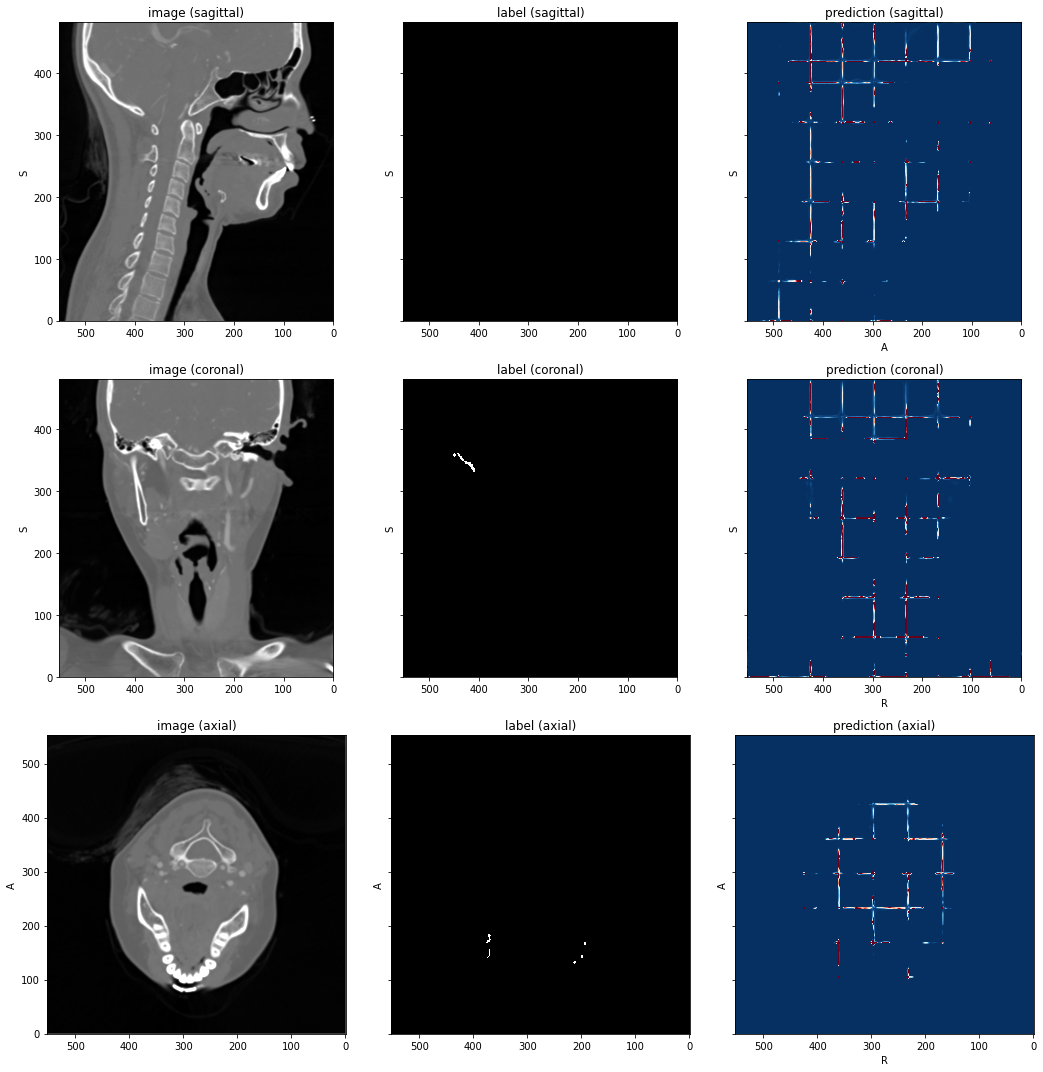

In [15]:
subject.plot(figsize=(15, 15), cmap_dict={'prediction': 'RdBu_r'})

In [16]:
subject.prediction.save('./output/prediction_multichannel_loss.nii.gz')